# The landscape of cancer driver genes
Landscape of all cancer driver genes detected by the method across all cohorts

In [14]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os
import numpy as np
#from tqdm import tqdm
import warnings
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import re

In [15]:
# Names and colors

colors_dic = {"Oncodrive3D" : "#ffad48", 
              "HotMAPS" : "#024b79", 
              "OncodriveCLUSTL" : "#43b7c2", 
              "smRegions" : "lightgray", 
              "CBaSE" : "lightgray", 
              "dNdScv" : "lightgray", 
              "MutPanning" : "lightgray", 
              "OncodriveFML" : "lightgray",
              "Random" : "pink"}

names_dic = {"o3d" : "Oncodrive3D", 
             "hotmaps" : "HotMAPS", 
             "clustl" : "OncodriveCLUSTL", 
             "smreg" : "smRegions", 
             "cbase" : "CBaSE", 
             "dndscv" : "dNdScv", 
             "mutpan" : "MutPanning", 
             "fml" : "OncodriveFML",
             "random" : "Random"}

In [16]:
SUBDIR = "human_mane_raw"
RUN = "run_2024-07-01_16-04-14"
# lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "seismic", "dndscv", "mutpan", "fml", "random"]
# lst_methods = ["o3d", "hotmaps", "clustl", "random"]

datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"
intogen_output = f"{datasets}/output/cancer_202404/intogen_output"
genetable_path = f"/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/data/results/{SUBDIR}/{RUN}.genetable.tsv"

In [17]:
genetable = pd.read_csv(genetable_path, sep="\t", dtype={1 : str, 2 : str, 3 : int})
genetable = genetable[[not cohort.startswith("ICGC") for cohort in genetable["Cohort"]]].reset_index(drop=True)
genetable_subset = genetable[genetable["Cohort"].str.startswith("TCGA")]
genetable_subset

,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
3062778,NFE2L2,Q16236,Processed,1,0,0.0,0.0,0.0,6.0,0.000000,...,0.002892,0.380525,3.0,0.000001,0.001441,NaN,NaN,NaN,LUSC,TCGA_WXS_LUSC
3062779,TP53,K7PPA8,Processed,1,0,1.0,0.0,0.0,11.0,0.000000,...,0.000055,0.073971,1.0,0.000001,0.001441,0.0,9.534979e-56,1.202361e-51,LUSC,TCGA_WXS_LUSC
3062780,PIK3CA,P42336,Processed,1,0,2.0,0.0,0.0,53.0,0.000388,...,0.000004,0.007465,29.0,0.000310,0.148955,1.0,8.013395e-12,5.052445e-08,LUSC,TCGA_WXS_LUSC
3062781,CDKN2A,K7PML8,Processed,1,0,3.0,0.0,0.0,5.0,0.000000,...,0.000399,0.266155,5.0,0.000001,0.001441,NaN,NaN,NaN,LUSC,TCGA_WXS_LUSC
3062782,HRAS,P01112,Processed,1,0,4.0,0.0,0.0,990.0,0.033670,...,0.003380,0.380525,2313.0,0.129510,0.927878,2046.0,1.413890e-01,7.547557e-01,LUSC,TCGA_WXS_LUSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4582141,XKRY2,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG
4582142,BCORL2,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG
4582143,CYorf15A,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG
4582144,CYorf15B,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG


In [33]:
def get_hits(genetable_df, alpha=0.01):
    
    genetable_df = genetable_df[genetable_df["o3d_qval"] < 0.01]
    genetable_df = genetable_df[["Gene", "Uniprot_ID", "Cancer", "Cohort", "CGC", "Fish", "o3d_qval"]].reset_index(drop=True)
    genetable_df = genetable_df.rename(columns={"o3d_qval" : "Oncodrive3D"})
    genetable_df["Oncodrive3D"] = 1
    
    return genetable_df


def get_top_cohorts(genetable_df, cohort_df):
    
    top_cohorts = cohort_df.sort_values("SAMPLES", ascending=False).reset_index(drop=True).COHORT.values
    
    return [cohort for cohort in top_cohorts if cohort in genetable_df["Cohort"].values]


def get_gene_cohorts_binary(genetable_df, cohort_df, 
                            top_cohorts_n=20, top_genes_n=20, 
                            anomaly_dict=None,
                            rm_empty_cols=True,
                            log_score=False):
    
    hits_df = get_hits(genetable_df)
    gene_hits_count = hits_df.groupby("Gene").sum()[["Oncodrive3D"]].sort_values("Oncodrive3D", ascending=False)
    cohort_hits_count = hits_df.groupby("Cohort").sum()[["Oncodrive3D"]].sort_values("Oncodrive3D", ascending=False)
    top_genes = gene_hits_count[:top_genes_n].index
    top_cohorts = get_top_cohorts(genetable_df, cohort_df)[:top_cohorts_n]
    
    df = pd.DataFrame(0, index=top_cohorts, columns=top_genes)
    for cohort in top_cohorts:
        genes = hits_df[hits_df["Cohort"] == cohort].Gene.values
        genes = [gene for gene in genes if gene in df.columns]
        if anomaly_dict:
            scores = [np.log(anomaly_dict[f"{gene}-{cohort}"]) if log_score else anomaly_dict[f"{gene}-{cohort}"] for gene in genes]    
            df.loc[cohort, genes] = scores
        else:
            df.loc[cohort, genes] = 1
            
    if anomaly_dict:
        df = df.replace([np.inf, -np.inf], np.nan)
        max_value = df.max().max()
        df = df.fillna(max_value)
    
    df = df.T 
    if len(cohort_df) == 1:
        df = df.loc[hits_df.Gene]
        
    if rm_empty_cols:
        if anomaly_dict:
            df = df.loc[:, ~(df == 0).all()]
        else:
            df = df.loc[:, ~(df == False).all()]
    
    return df, hits_df, gene_hits_count.loc[df.index], cohort_hits_count.loc[[cohort for cohort in cohort_hits_count.index if cohort in df.columns]]
    

def get_gene_annotation(df, genetable):
    
    cgc_genes = genetable[genetable["CGC"] == 1].Gene.unique()
    fish_genes = genetable[genetable["Fish"] == 1].Gene.unique()
    gene_annotation = ["CGC" if gene in cgc_genes else "Fishy" if gene in fish_genes else "Not annotated" for gene in df.index]
    gene_annotation = pd.Series(gene_annotation, name="Annotation")
    lut = {"CGC": '#ff7f0e', 
           "Fishy": '#2ca02c', 
           "Not annotated": '#7f7f7f'}
    gene_colors = gene_annotation.map(lut)
    
    return gene_colors, lut

In [19]:
def get_anomaly_df(genetable_df, o3d_output_dir):
    
    lst_cohort = []
    for cohort in genetable_df.Cohort.unique():
        df_cohort = pd.read_csv(f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv")
        df_cohort = df_cohort[["Cohort", "Gene", "Uniprot_ID", "qval", "C_gene", "C_pos", "Score_obs_sim_top_vol"]]
        df_cohort = df_cohort.dropna(subset="qval").rename(columns={"Score_obs_sim_top_vol" : "Clustering_score"})
        lst_cohort.append(df_cohort)

    anomaly_df = pd.concat(lst_cohort).reset_index(drop=True)
    anomaly_df = anomaly_df.merge(genetable_df[["Cohort", "Gene", "CGC", "Fish"]], on=["Cohort", "Gene"], how="left")
    
    return anomaly_df


def create_custom_colormap(cmap="Reds"):
    colors = sns.color_palette(cmap, as_cmap=True)
    colors = colors(np.linspace(0, 0.9, 256)) # Soften the dark color
    
    return LinearSegmentedColormap.from_list("CustomReds", colors)


def plot_landscape(df, gene_colors, lut, 
                   gene_hits_count, cohort_hits_count,
                   df_anomaly=None,
                   figsize=(16,14),
                   width_ratios=[1, 0.2],
                   height_ratios=[0.3, 1],
                   legend_box=(-5.5, 1.02),
                   ax1_margin=0.005,
                   ax4_margin=0.005,
                   wspace=0.02, 
                   hspace=0.05,
                   cbar_loc=[-0.01, 0.2, 0.02, .3],
                   intogen_label=False,
                   intogen_label_table=None,
                   filename="landscape_heatmap_tcga.png"):
    
    if df_anomaly is not None:
        df_binary = df
        df = df_anomaly
        cmap = "OrRd"
        cmap = create_custom_colormap()
    else:
        colors = ["lightgray", "gray"] 
        cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

    # Define the row and column labels
    row_labels = df.index
    col_labels = df.columns
    #col_labels = [ctype_dict[cohort] for cohort  in col_labels]

    gene_sums = gene_hits_count["Oncodrive3D"].values
    cohort_sums = cohort_hits_count["Oncodrive3D"].values

    # Create a figure with a grid layout for heatmap and bars
    fig, ax = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
    ax1 = ax[0,0]
    ax2 = ax[0,1]
    ax3 = ax[1,0]
    ax4 = ax[1,1]

    # Create the heatmap
    sns.heatmap(df, annot=False, cmap=cmap, cbar=False, xticklabels=col_labels, yticklabels=row_labels, ax=ax3, lw=0.5, linecolor="black")
    ax3.set_xticklabels(col_labels, rotation=45, rotation_mode="anchor", ha='right') 
    ax3.set_xlabel("Cohort")
    ax3.set_ylabel("Gene")
    ax3.set_xlabel("")
    ax3.set_ylabel("")
    ax3.spines['bottom'].set_visible(True)
    ax3.spines['right'].set_visible(True)
    for i, label in enumerate(ax3.get_yticklabels()):
        label.set_color(gene_colors[i])

    # Add bars for the top axis
    ax4.barh(np.arange(len(gene_sums)), gene_sums, color='#cdc9e8', edgecolor="black")
    ax4.set_yticks(np.arange(len(gene_sums)))
    ax4.set_yticklabels([])
    ax4.set_xlabel("Cohort count")
    ax4.invert_yaxis()

    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')
    ax4.spines['bottom'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    # Add bars for the right axis
    row_sums = np.sum(df, axis=1)
    ax1.bar(np.arange(len(cohort_sums)), cohort_sums, color='#ffddb3', edgecolor="black")
    ax1.set_xticks(np.arange(len(cohort_sums)))
    ax1.set_ylabel("Gene count")
    ax1.set_xticklabels([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Details
    ax2.remove()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    ax1.margins(x=ax1_margin, tight=True)
    ax4.margins(y=ax4_margin, tight=True)

    handles, labels = ax3.get_legend_handles_labels()
    if intogen_label:
        handles.append(mpatches.Patch(facecolor=lut["Detected"], edgecolor="black", label='Detected', lw=0.5))
        handles.append(mpatches.Patch(facecolor=lut["Not detected"], edgecolor="black", label="Not detected", lw=0.5))
        legend = plt.legend(handles=handles, bbox_to_anchor=legend_box, frameon=False, 
                            title="Detected in IntOGen", title_fontsize=11, fontsize=11)
    else:
        handles.append(mpatches.Patch(facecolor=lut["CGC"], edgecolor="black", label='CGC', lw=0.5))
        handles.append(mpatches.Patch(facecolor=lut["Fishy"], edgecolor="black", label="Fishy", lw=0.5))
        handles.append(mpatches.Patch(facecolor="#bfbfbf", edgecolor="black", label="Not annotated", lw=0.5))
        legend = plt.legend(handles=handles, bbox_to_anchor=legend_box, frameon=False, 
                            title="Gene annotation", title_fontsize=11, fontsize=11)
    for text in legend.get_texts():
        text.set_color(lut[text.get_text()])
    
    if df_anomaly is not None:
        # Set cbar
        cbar_ax = fig.add_axes(cbar_loc) 
        cbar = fig.colorbar(ax3.collections[0], cax=cbar_ax)
        cbar.set_label('Clustering score log ratio', fontsize=11) 
        
        # Overlay stars on top of the heatmap
        for i in range(len(row_labels)):
            for j in range(len(col_labels)):
                if df_binary.iloc[i, j] == 1:
                    ax3.text(j + 0.5, i + 0.65, '*', ha='center', va='center', fontsize=12, color='black')
           
        # Overlay ^ for IntOGen hits
        if intogen_label_table is not None:   
            for i in range(len(row_labels)):
                for j in range(len(col_labels)):
                    if intogen_label_table.iloc[i, j] == 1:
                        ax3.text(j + 0.5, i + 0.65, '^', ha='center', va='top', fontsize=12, color='black')

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

## Heatmaps

In [20]:
genetable_subset[["Gene", "Cohort", "CGC"]]
#cohort_df = pd.read_csv(f"{datasets}/cohorts.tsv", sep="\t")
cohort_ttype_dict = {cohort : ttype for cohort, ttype in cohort_df[["COHORT", "CANCER_TYPE"]].values}
cohort_ttype_dict

{'HARTWIG_WGS_BLCA_2023': 'BLCA',
 'HARTWIG_WGS_EGC_2023': 'EGC',
 'HARTWIG_WGS_LMS_2023': 'LMS',
 'CBIOP_WGS_STAD_ONCOSG_2018': 'STAD',
 'CBIOP_WXS_CM_VALLEN_2018': 'MEL',
 'CBIOP_WXS_BLCA_VALLEN_2018': 'BLCA',
 'STJUDE_WGS_D_AML_2018': 'AML',
 'HARTWIG_WGS_HCC_2023': 'HCC',
 'HARTWIG_WGS_UCEC_2023': 'UCEC',
 'STJUDE_WGS_D_EPD_2018': 'EPM',
 'HARTWIG_WGS_COADREAD_2023': 'COADREAD',
 'HARTWIG_WGS_GB_2023': 'GB',
 'HARTWIG_WGS_ANSC_2023': 'ANSC',
 'HARTWIG_WGS_RCC_2023': 'RCC',
 'STJUDE_WGS_M_OS_2018': 'OS',
 'STJUDE_WGS_D_OS_2018': 'OS',
 'STJUDE_WGS_D_CM_2018': 'MEL',
 'CBIOP_WXS_BCC_UNIGE_2016_TREAT': 'BCC',
 'STJUDE_WGS_D_RHBDS_2018': 'RMS',
 'CBIOP_WGS_PRAD_EURUROL_2017': 'PRAD',
 'STJUDE_WGS_D_ACC_2018': 'ACC',
 'HARTWIG_WGS_WDTC_2023': 'WDTC',
 'STJUDE_WGS_D_EWS_2018': 'ES',
 'HARTWIG_WGS_UTUC_2023': 'UTUC',
 'HARTWIG_WGS_GIST_2023': 'GIST',
 'HARTWIG_WGS_LIPO_2023': 'LIPO',
 'STJUDE_WGS_D_MB_2018': 'MBL',
 'CBIOP_WXS_ANGS_TREATED_2020': 'ANGS',
 'HARTWIG_WGS_GBC_2023': 'GBC',
 '

In [21]:
datasets = "/workspace/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404"
cgc_df = pd.read_csv(f"{datasets}/CGC_list_v99.tsv", sep = "\t")
cgc_df[:60]

,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,A1CF,APOBEC1 complementation factor,29974.0,10:50799421-50885675,2,NaN,10q11.23,yes,NaN,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,NaN,NaN,"ACF,ACF64,ACF65,APOBEC1CF,ASP,CCDS73133.1,ENSG..."
1,ABI1,abl-interactor 1,10006.0,10:26746593-26860935,1,Yes,10p12.1,yes,NaN,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"ABI-1,CCDS7150.1,E3B1,ENSG00000136754.17,NM_00..."
2,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25.0,9:130713946-130885683,1,Yes,9q34.12,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",NaN,NaN,"ABL,CCDS35165.1,ENSG00000097007.17,JTK7,NM_007..."
3,ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27.0,1:179099327-179229601,1,NaN,1q25.2,yes,NaN,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,NaN,NaN,"ABLL,ARG,CCDS30947.1,ENSG00000143322.19,NM_007..."
4,ACKR3,atypical chemokine receptor 3,57007.0,2:236569641-236582358,1,Yes,2q37.3,yes,NaN,lipoma,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,NaN,NaN,"CCDS2516.1,CMKOR1,CXCR7,ENSG00000144476.5,GPR1..."
5,ACSL3,acyl-CoA synthetase long-chain family member 3,2181.0,2:222860934-222944639,1,Yes,2q36.1,yes,NaN,prostate,NaN,NaN,E,Dom,fusion,T,ETV1,NaN,NaN,"ACS3,CCDS2455.1,ENSG00000123983.13,FACL3,NM_00..."
6,ACSL6,acyl-CoA synthetase long-chain family member 6,23305.0,5:131949973-132011662,2,NaN,5q31.1,yes,NaN,"AML, AEL",NaN,NaN,L,Dom,fusion,T,ETV6,NaN,NaN,"ACS2,CCDS34229.1,ENSG00000164398.12,FACL6,KIAA..."
7,ACVR1,"activin A receptor, type I",90.0,2:157736444-157875111,1,Yes,2q24.1,yes,NaN,DIPG,NaN,NaN,O,Dom,oncogene,Mis,NaN,yes,Fibrodysplasia ossificans progressiva,"ACVR1A,ACVRLK2,ALK2,CCDS2206.1,ENSG00000115170..."
8,ACVR1B,Activin A Receptor Type 1B,91.0,12:51951701-51994217,1,NaN,12q13.13,yes,NaN,pancreatic cancer,NaN,NaN,E,NaN,TSG,"D, F, Mis, N",NaN,NaN,NaN,"ACVRLK4,ALK4,ActRIB,CCDS44894.2,ENSG0000013550..."
9,ACVR2A,activin A receptor type 2A,92.0,2:147844517-147930824,1,Yes,2q23.1,yes,NaN,"large intestine carcinoma, stomach carcinoma, ...",NaN,NaN,E,Rec,TSG,"Mis, N, F",NaN,NaN,NaN,"ACTRII,ACVR2,CCDS33301.1,ENSG00000121989.14,NM..."


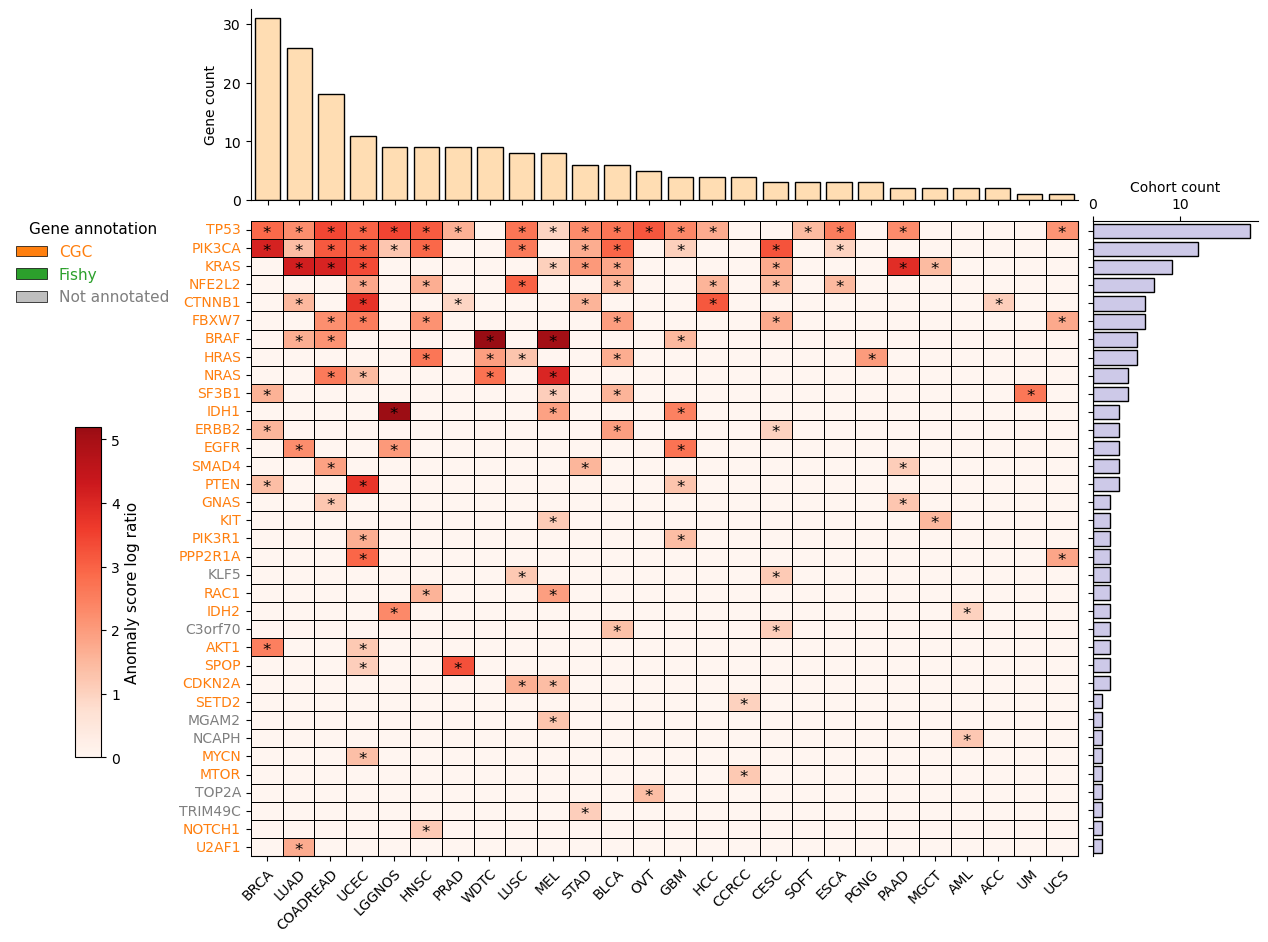

In [23]:
top_cohorts_n=50
top_genes_n=35

o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_subset, 
                                                                          cohort_df, 
                                                                          top_cohorts_n=top_cohorts_n, 
                                                                          top_genes_n=top_genes_n, 
                                                                          anomaly_dict=False)

df_binary.columns = [cohort.split("_")[2] for cohort in df_binary.columns]
df_anomaly.columns = [cohort.split("_")[2] for cohort in df_anomaly.columns]
gene_colors, lut = get_gene_annotation(df_binary, genetable)

# plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=None,
#                figsize=(13,8),
#                width_ratios=[1, 0.2],
#                height_ratios=[0.3, 1],
#                legend_box=(-5.5, 1.02),
#                ax1_margin=0.005,
#                ax4_margin=0.005,
#                wspace=0.03, 
#                hspace=0.05)

plot_landscape(df=df_binary, 
               gene_colors=gene_colors, 
               gene_hits_count=gene_hits_count, 
               cohort_hits_count=cohort_hits_count,
               lut=lut, 
               df_anomaly=df_anomaly,
               figsize=(13,11),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-5.5, 1.02),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.05,)
               #filename="landscape_heatmap.png")

# WORKING HERE

## Notes
- Look at what happened to the score if not in log scale
- Why was in log scale?
- Probably change the color palette
- Add TOP bar colors according to the CGC in cancer, CGC in other cancer, not CGC
- Add annotation axis on the right to annotated for CGC, OncoKB, Fishy, whatever else.. plus IntOGen hit, each individual method in IntOGen
    - AFTER CONSENSUS VOTING or ANY HIT?
- I could color the RIGHT bar according to the cancer type (probably, not really useful for TCGA but useful for the all cohorts one)

In [35]:
o3d_output

,Cohort,Gene,Uniprot_ID,qval,C_gene,C_pos,Clustering_score,CGC,Fish
0,TCGA_WXS_LUSC,NFE2L2,Q16236,0.0,1,[31 29 30 26 27 24 79 80 81 77 34],20.512420,1,0
1,TCGA_WXS_LUSC,TP53,K7PPA8,0.0,1,[245 241 242 273 249 175 248 238 194 173 274 2...,14.640403,1,0
2,TCGA_WXS_LUSC,PIK3CA,P42336,0.0,1,[ 542 545 547 539 1045 1047],13.669229,1,0
3,TCGA_WXS_LUSC,CDKN2A,K7PML8,0.0,1,[ 83 114 84 85 118 81 50 108 53 20 48],5.202005,1,0
4,TCGA_WXS_LUSC,HRAS,P01112,0.0,1,[13 12 61],3.588907,1,0
...,...,...,...,...,...,...,...,...,...
36091,TCGA_WXS_PGNG,SUSD4,Q5VX71,1.0,0,NaN,1.668006,0,0
36092,TCGA_WXS_PGNG,PMM1,A0A024R1U5,1.0,0,NaN,1.332350,0,0
36093,TCGA_WXS_PGNG,NAGK,A0A384N6G7,1.0,0,NaN,1.287737,0,0
36094,TCGA_WXS_PGNG,ADH6,P28332,1.0,0,NaN,1.279473,0,1


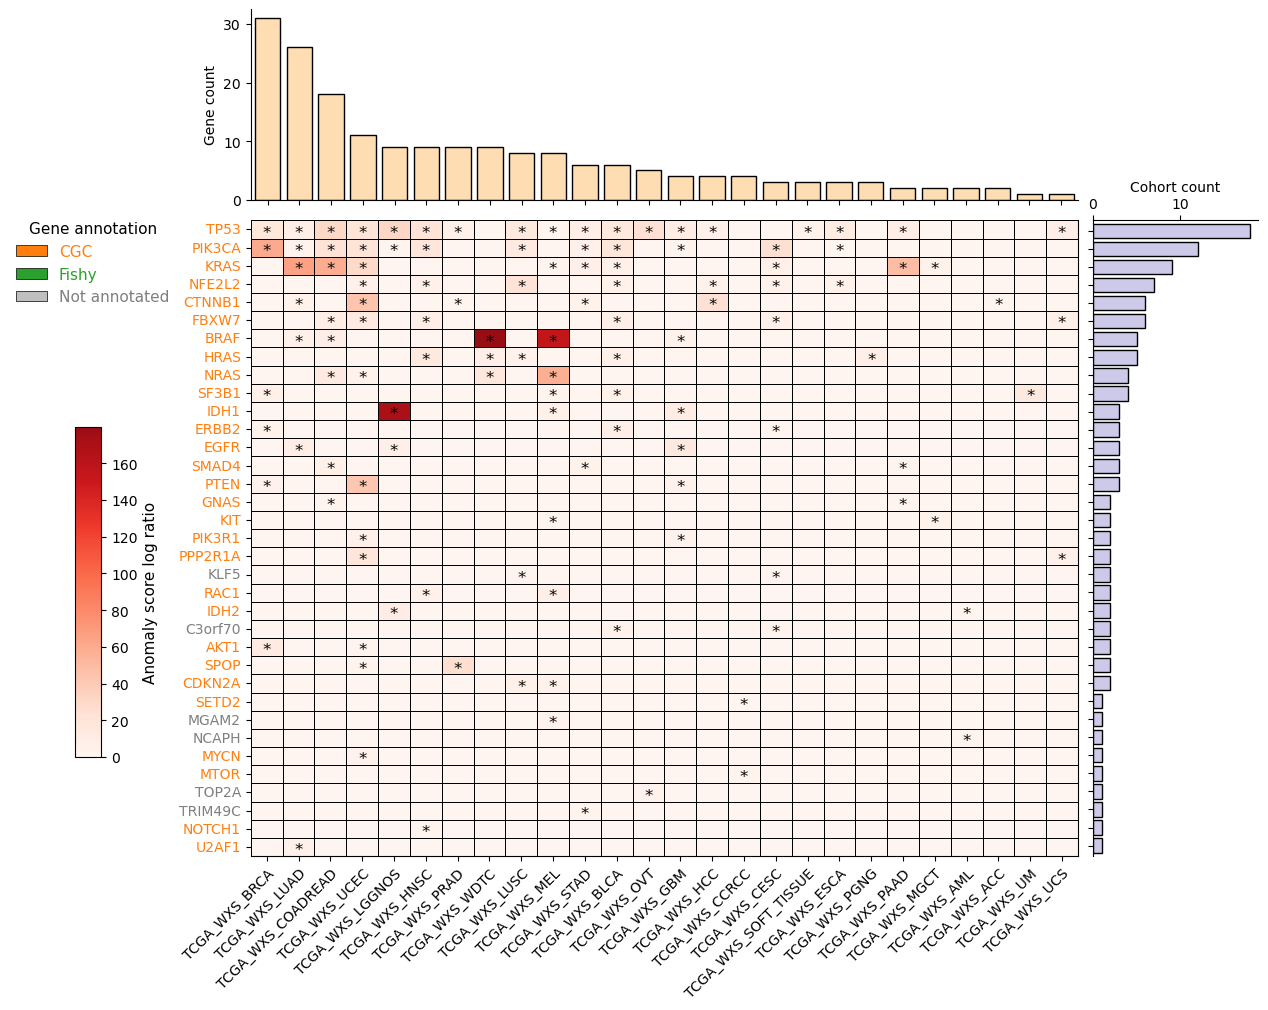

In [34]:
top_cohorts_n=50
top_genes_n=35

o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict)

# df_binary.columns = [cohort.split("_")[2] for cohort in df_binary.columns]
# df_anomaly.columns = [cohort.split("_")[2] for cohort in df_anomaly.columns]
gene_colors, lut = get_gene_annotation(df_binary, genetable)

plot_landscape(df=df_binary, 
               gene_colors=gene_colors, 
               gene_hits_count=gene_hits_count, 
               cohort_hits_count=cohort_hits_count,
               lut=lut, 
               df_anomaly=df_anomaly,
               figsize=(13,11),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-5.5, 1.02),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.05,)

# TO HERE

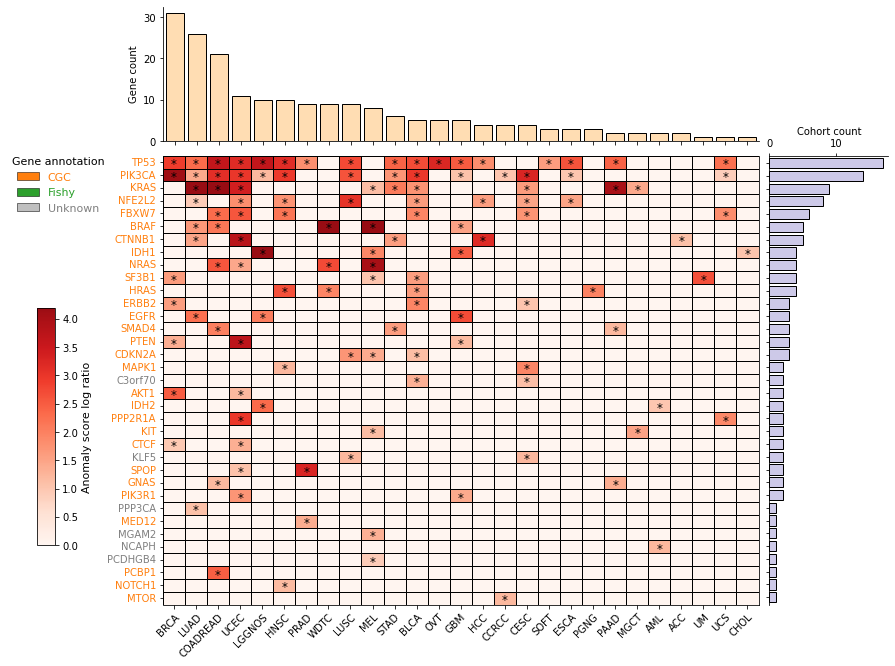

In [345]:
top_cohorts_n=50
top_genes_n=35

o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_subset, 
                                                                          cohort_df, 
                                                                          top_cohorts_n=top_cohorts_n, 
                                                                          top_genes_n=top_genes_n, 
                                                                          anomaly_dict=False)

df_binary.columns = [cohort.split("_")[2] for cohort in df_binary.columns]
df_anomaly.columns = [cohort.split("_")[2] for cohort in df_anomaly.columns]
gene_colors, lut = get_gene_annotation(df_binary, genetable)

# plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=None,
#                figsize=(13,8),
#                width_ratios=[1, 0.2],
#                height_ratios=[0.3, 1],
#                legend_box=(-5.5, 1.02),
#                ax1_margin=0.005,
#                ax4_margin=0.005,
#                wspace=0.03, 
#                hspace=0.05)

plot_landscape(df=df_binary, gene_colors=gene_colors, 
               gene_hits_count=gene_hits_count, cohort_hits_count=cohort_hits_count,
               lut=lut, df_anomaly=df_anomaly,
               figsize=(13,11),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-5.5, 1.02),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.05,
               filename="landscape_heatmap.png")

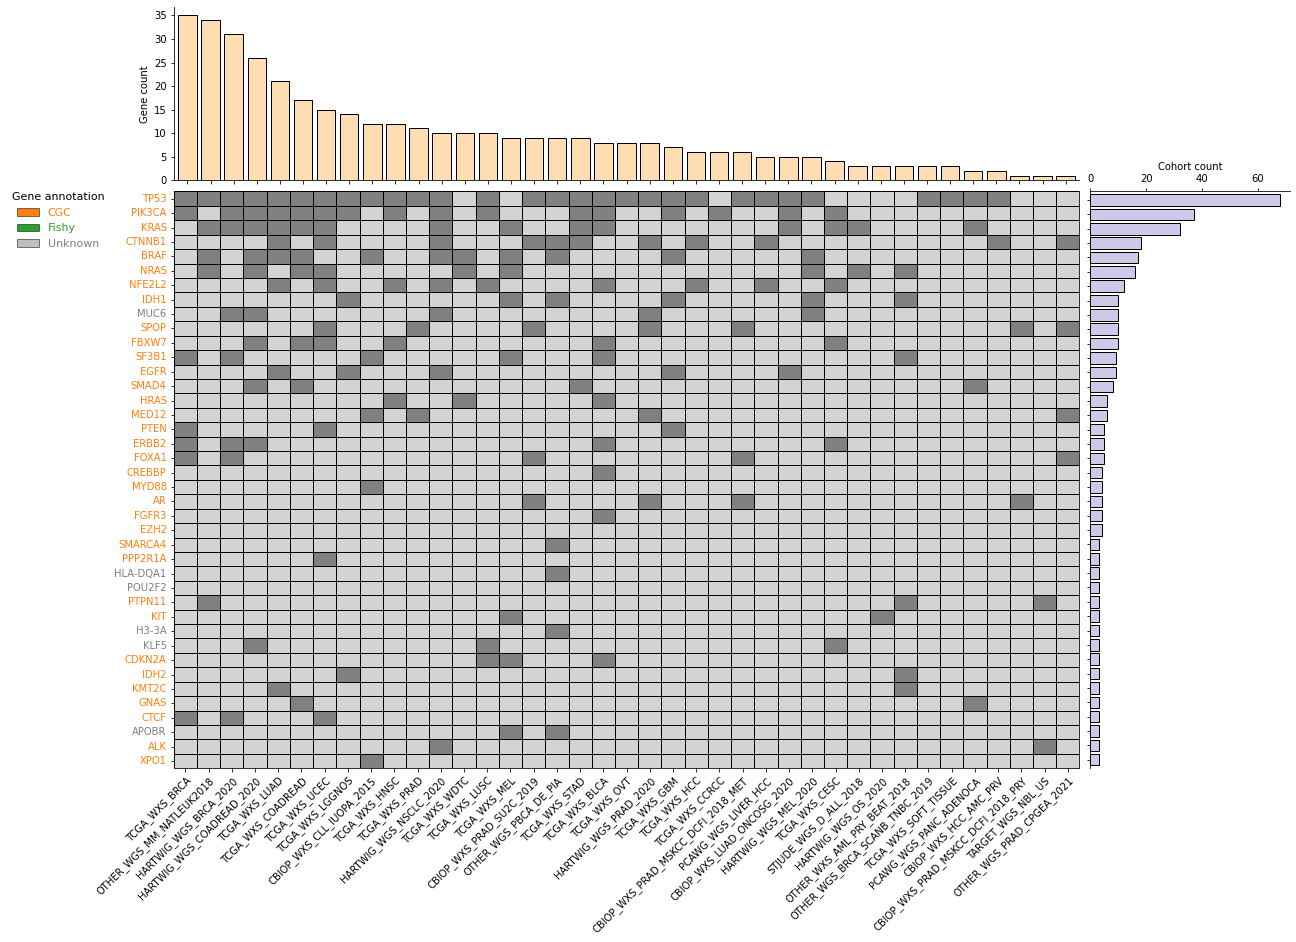

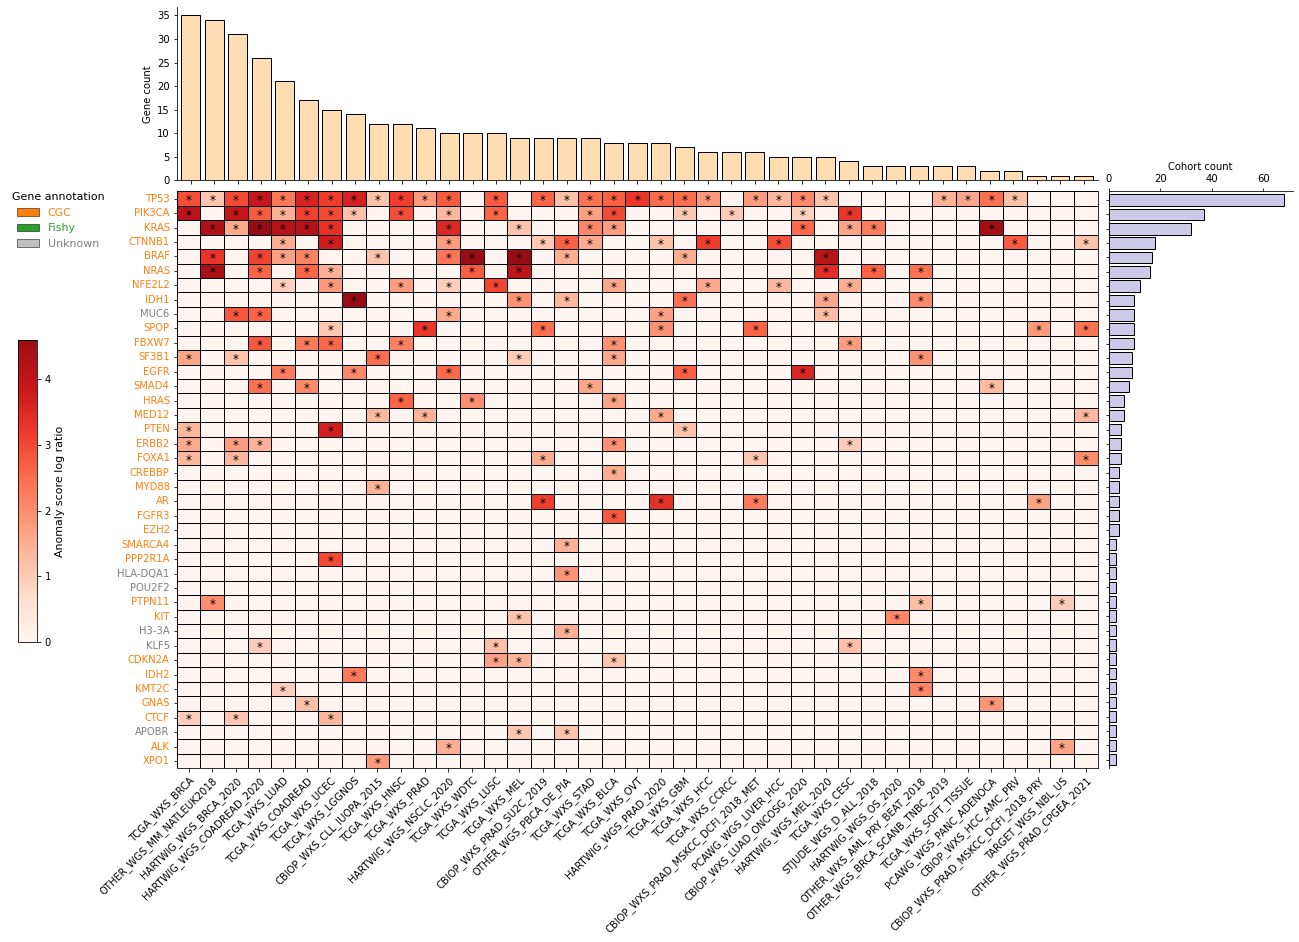

In [13]:
top_cohorts_n=40
top_genes_n=40

o3d_output = get_anomaly_df(genetable, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=False)

gene_colors, lut = get_gene_annotation(df_binary, genetable)

plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=None,
               gene_hits_count=gene_hits_count, cohort_hits_count=cohort_hits_count,
               figsize=(20,14),
               width_ratios=[1, 0.22],
               height_ratios=[0.3, 1],
               legend_box=(-4.9, 1.0156),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.02, 
               hspace=0.03)

plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=df_anomaly,
               gene_hits_count=gene_hits_count, cohort_hits_count=cohort_hits_count,
               figsize=(20,14),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-5.4, 1.0156),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.02, 
               hspace=0.03,
               cbar_loc=[0.015, 0.25, 0.0133, .3],
               filename="landscape_heatmap_all_cohorts.png")

In [18]:
df_binary.loc[df_binary["OTHER_WGS_PBCA_DE_PIA"] == 1, "OTHER_WGS_PBCA_DE_PIA"]

Gene
TP53        1
CTNNB1      1
BRAF        1
IDH1        1
SMARCA4     1
HLA-DQA1    1
H3-3A       1
APOBR       1
Name: OTHER_WGS_PBCA_DE_PIA, dtype: int64

In [25]:
genetable[(genetable["Gene"] == "IGLL5") & (genetable["o3d_qval"] < 0.01)]

,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
2428964,IGLL5,B9A064,Processed,0,0,2.0,0.0,0.0,17734.0,1.000000,...,0.077143,0.223067,7975.0,1.00000,1.0,NaN,NaN,NaN,DLBCLNOS,OTHER_WGS_DLBCL_NATCOM_2018
2642228,IGLL5,B9A064,Processed,0,0,4.0,0.0,0.0,11225.0,0.626789,...,0.556394,0.592594,15605.0,0.99999,1.0,NaN,NaN,NaN,PCM,OTHER_WGS_MM_NATLEUK2018


## Non annotated genes

In [7]:
intogen_df = pd.read_csv("/workspace/projects/clustering_3d/o3d_analysys/datasets/Intogen_Compendium_Cancer_Genes.tsv", sep="\t")
intogen_genes = intogen_df.SYMBOL.unique()

In [8]:
def get_intogen_annotation(df, intogen_genes):
    
    gene_annotation = ["Detected" if gene in intogen_genes else "Not detected" for gene in df.index]
    gene_annotation = pd.Series(gene_annotation, name="Annotation")
    lut = {"Detected": '#4d4dff', 
           "Not detected": '#b30000'}
    gene_colors = gene_annotation.map(lut)
    
    return gene_colors, lut


def get_intogen_genes_by_cohort(df_binary, intogen_df):

    df = pd.DataFrame(0, index=df_binary.index, columns=df_binary.columns)
    for gene in df.index:
        for cohort in df.columns:
            if len(intogen_df[(intogen_df["SYMBOL"] == gene) & (intogen_df["COHORT"] == cohort)]) > 0:
                df.loc[gene, cohort] = 1
                
    return df

In [9]:
genetable = genetable[(genetable["CGC"] == 0) & (genetable["Fish"] == 0)].reset_index(drop=True)
top_cohorts_n=150
top_genes_n=24

o3d_output = get_anomaly_df(genetable, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, _, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                      cohort_df, 
                                                      top_cohorts_n=top_cohorts_n, 
                                                      top_genes_n=top_genes_n, 
                                                      anomaly_dict=anomaly_dict)

df_binary, _, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                      cohort_df, 
                                                      top_cohorts_n=top_cohorts_n, 
                                                      top_genes_n=top_genes_n, 
                                                      anomaly_dict=False)

gene_colors, lut = get_intogen_annotation(df_binary, intogen_genes)
intogen_gene_by_cohort = get_intogen_genes_by_cohort(df_binary, intogen_df)
intogen_gene_by_cohort

,OTHER_WGS_MM_NATLEUK2018,HARTWIG_WGS_BRCA_2020,HARTWIG_WGS_COADREAD_2020,HARTWIG_WGS_NSCLC_2020,TCGA_WXS_LUSC,TCGA_WXS_MEL,CBIOP_WXS_PRAD_SU2C_2019,OTHER_WGS_PBCA_DE_PIA,TCGA_WXS_STAD,TCGA_WXS_BLCA,...,PEDCBIOP_WXS_HGG_PRY,PCAWG_WGS_LYMPH_BNHL,OTHER_WXS_NPC_NATCOM2017,PEDCBIOP_WXS_MBL_GP4_PRY,CBIOP_WXS_BLCA_BGI,CBIOP_WXS_BCC_UNIGE_2016_UNTREAT,CGCI_WGS_BL_2020,HARTWIG_WGS_GBM_2020,CBIOP_WXS_DLBC_BROAD_2012,CBIOP_WXS_BLCA_DFARBER_MSKCC_2014
Gene,,,,,,,,,,,,,,,,,,,,,
MUC6,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
POU2F2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
KLF5,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
H3-3A,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
APOBR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HLA-DQA1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HLA-DQB1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IGLL5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
USP7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


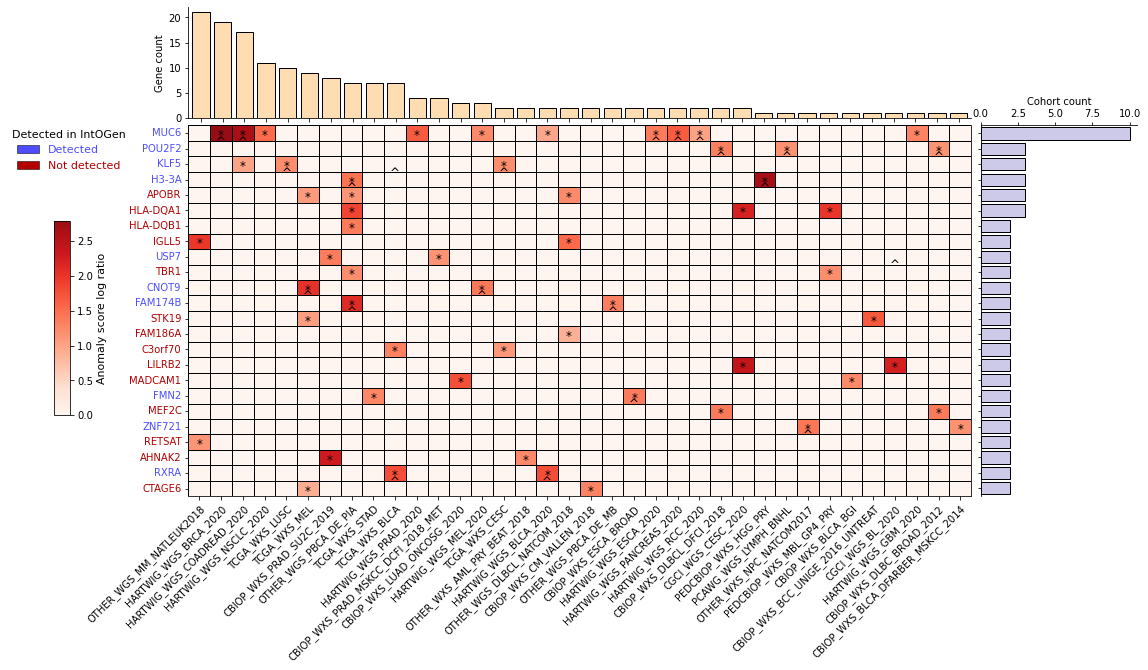

In [507]:
genetable = genetable[(genetable["CGC"] == 0) & (genetable["Fish"] == 0)].reset_index(drop=True)
top_cohorts_n=150
top_genes_n=24

o3d_output = get_anomaly_df(genetable, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, _, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                      cohort_df, 
                                                      top_cohorts_n=top_cohorts_n, 
                                                      top_genes_n=top_genes_n, 
                                                      anomaly_dict=anomaly_dict)

df_binary, _, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                      cohort_df, 
                                                      top_cohorts_n=top_cohorts_n, 
                                                      top_genes_n=top_genes_n, 
                                                      anomaly_dict=False)

gene_colors, lut = get_intogen_annotation(df_binary, intogen_genes)
intogen_gene_by_cohort = get_intogen_genes_by_cohort(df_binary, intogen_df)

plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=df_anomaly,
               gene_hits_count=gene_hits_count, cohort_hits_count=cohort_hits_count,
               figsize=(17,9),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-5.4, 1.0156),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.02, 
               hspace=0.03,
               cbar_loc=[0.015, 0.25, 0.0133, .3],
               intogen_label=True,
               intogen_label_table=intogen_gene_by_cohort,
               filename="landscape_heatmap_unknown_all_cohorts.png")

## Anomaly score density plots

In [49]:
def replace_inf(series):
    
    series = series.copy()
    max_value = series.values[np.isfinite(series.values)].max()
    return series.replace([np.inf, -np.inf], max_value * 2, inplace=False)

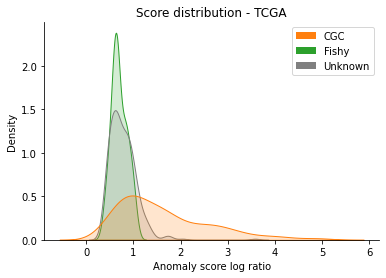

In [81]:
# Get df with scores
o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
o3d_output["Clustering_score"] = replace_inf(o3d_output["Clustering_score"])
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output["Annotation"] = o3d_output.apply(lambda x: "CGC" if x["CGC"] == 1 else "Fishy" if x["Fish"] == 1 else "Not annotated", axis=1)

## Plot 
plt.figure(figsize=(6, 4))
palette = {'CGC': lut["CGC"], 'Fishy': lut["Fishy"], 'Not annotated': lut["Not annotated"]}
sns.kdeplot(data=o3d_output, x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Anomaly score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - TCGA", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["CGC"], label="CGC"),
           mpatches.Patch(facecolor=lut["Fishy"], label="Fishy"),
           mpatches.Patch(facecolor=lut["Not annotated"], label="Not annotated")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("score_distribution_tcga.png", dpi=300, bbox_inches='tight')
plt.show()

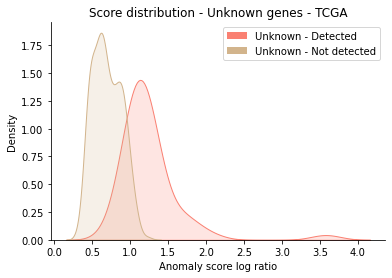

In [82]:
# Get df with scores
o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
o3d_output["Clustering_score"] = replace_inf(o3d_output["Clustering_score"])
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[(o3d_output["CGC"] == 0) & (o3d_output["Fish"] == 0)]
o3d_output["Annotation"] = o3d_output["C_gene"]
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)

## Plot 
plt.figure(figsize=(6, 4))
palette = {1: "salmon", 0: "tan"}
sns.kdeplot(data=o3d_output, x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Anomaly score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - Not annotated genes - TCGA", fontsize=12)

handles = [mpatches.Patch(facecolor="salmon", label="Not annotated - Detected"),
           mpatches.Patch(facecolor="tan", label="Not annotated - Not detected")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("score_distribution_unknown_tcga.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Get df with scores with annotations
o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
o3d_output["Clustering_score"] = replace_inf(o3d_output["Clustering_score"])
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output2 = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output2["Annotation"] = o3d_output2.apply(lambda x: "CGC" if x["CGC"] == 1 else "Fishy" if x["Fish"] == 1 else "Not annotated", axis=1)

# Get df with scores of not annotated genes
o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[(o3d_output["CGC"] == 0) & (o3d_output["Fish"] == 0)]
o3d_output["Annotation"] = o3d_output["C_gene"]
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output["Annotation"] = o3d_output["Annotation"].map({1 : "Not annotated - Detected", 0 : "Not annotated - Not detected"})

# Concat
o3d_output = pd.concat((o3d_output, o3d_output2)).reset_index(drop=True)


## Plot 
plt.figure(figsize=(6, 4))
palette = {'CGC': lut["CGC"], 'Fishy': lut["Fishy"], 'Not annotated': lut["Not annotated"], "Not annotated - Detected" : "salmon", "Not annotated - Not detected" : "tan"}
annotation_ix = (o3d_output["Annotation"] == "CGC") | (o3d_output["Annotation"] == "Fishy") | (o3d_output["Annotation"] == "Not annotated")
sns.kdeplot(data=o3d_output[~annotation_ix], x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)
sns.kdeplot(data=o3d_output[annotation_ix], x='Clustering_score', hue='Annotation', fill=False, common_norm=False, palette=palette, alpha=0.8)

# Add labels and a legend
plt.xlabel('Anomaly score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - Annotated and detected - TCGA", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["CGC"], label="CGC"),
           mpatches.Patch(facecolor=lut["Fishy"], label="Fishy"),
           mpatches.Patch(facecolor=lut["Not annotated"], label="Not annotated"),
           mpatches.Patch(facecolor="salmon", label="Not annotated - Detected"),
           mpatches.Patch(facecolor="tan", label="Not annotated - Not detected")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("score_distribution_annotated_detected_tcga.png", dpi=300, bbox_inches='tight')
plt.show()

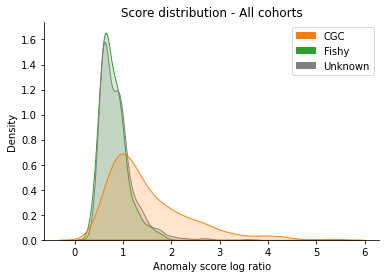

In [86]:
# Get df with scores
o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output["Clustering_score"] = replace_inf(o3d_output["Clustering_score"])
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output["Annotation"] = o3d_output.apply(lambda x: "CGC" if x["CGC"] == 1 else "Fishy" if x["Fish"] == 1 else "Not annotated", axis=1)

# Plot
plt.figure(figsize=(6, 4))
palette = {'CGC': lut["CGC"], 'Fishy': lut["Fishy"], 'Not annotated': lut["Not annotated"]}
sns.kdeplot(data=o3d_output, x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Anomaly score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["CGC"], label="CGC"),
           mpatches.Patch(facecolor=lut["Fishy"], label="Fishy"),
           mpatches.Patch(facecolor=lut["Not annotated"], label="Not annotated")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("score_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

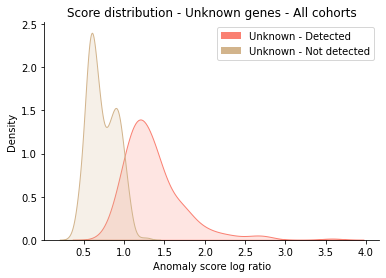

In [85]:
# Get df with scores
o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output["Clustering_score"] = replace_inf(o3d_output["Clustering_score"])
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[(o3d_output["CGC"] == 0) & (o3d_output["Fish"] == 0)]
o3d_output["Annotation"] = o3d_output["C_gene"]
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index()

## Plot 
plt.figure(figsize=(6, 4))
palette = {1: "salmon", 0: "tan"}
sns.kdeplot(data=o3d_output, x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Anomaly score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - Not annotated genes - All cohorts", fontsize=12)
handles = [mpatches.Patch(facecolor="salmon", label="Not annotated - Detected"),
           mpatches.Patch(facecolor="tan", label="Not annotated - Not detected")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("score_distribution_unknown.png", dpi=300, bbox_inches='tight')
plt.show()

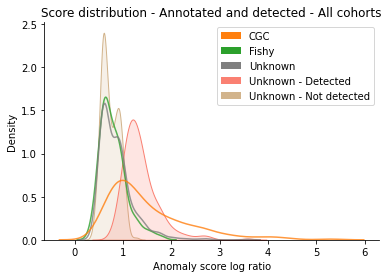

In [84]:
# Get df with scores with annotations
o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output["Clustering_score"] = replace_inf(o3d_output["Clustering_score"])
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output2 = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output2["Annotation"] = o3d_output2.apply(lambda x: "CGC" if x["CGC"] == 1 else "Fishy" if x["Fish"] == 1 else "Not annotated", axis=1)

# Get df with scores of not annotated genes
o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[(o3d_output["CGC"] == 0) & (o3d_output["Fish"] == 0)]
o3d_output["Annotation"] = o3d_output["C_gene"]
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output["Annotation"] = o3d_output["Annotation"].map({1 : "Not annotated - Detected", 0 : "Not annotated - Not detected"})

# Concat
o3d_output = pd.concat((o3d_output, o3d_output2)).reset_index(drop=True)


## Plot 
plt.figure(figsize=(6, 4))
palette = {'CGC': lut["CGC"], 'Fishy': lut["Fishy"], 'Not annotated': lut["Not annotated"], "Not annotated - Detected" : "salmon", "Not annotated - Not detected" : "tan"}
annotation_ix = (o3d_output["Annotation"] == "CGC") | (o3d_output["Annotation"] == "Fishy") | (o3d_output["Annotation"] == "Not annotated")
sns.kdeplot(data=o3d_output[~annotation_ix], x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)
sns.kdeplot(data=o3d_output[annotation_ix], x='Clustering_score', hue='Annotation', fill=False, common_norm=False, palette=palette, alpha=0.8)

# Add labels and a legend
plt.xlabel('Anomaly score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - Annotated and detected - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["CGC"], label="CGC"),
           mpatches.Patch(facecolor=lut["Fishy"], label="Fishy"),
           mpatches.Patch(facecolor=lut["Not annotated"], label="Not annotated"),
           mpatches.Patch(facecolor="salmon", label="Not annotated - Detected"),
           mpatches.Patch(facecolor="tan", label="Not annotated - Not detected")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("score_distribution_annotated_detected.png", dpi=300, bbox_inches='tight')
plt.show()

## Highlight some interesting cases

In [369]:
def int_lst_from_str(str_lst):
    
    numbers = re.findall(r'\d+', str_lst)
    
    return np.array([int(num) for num in numbers])


def get_pos_clust_freq(gene_df, pos):

    tot_count = len(gene_df)
    count = sum([pos in gene_df.iloc[i].C_pos for i in range(tot_count)])
    
    return count / tot_count


def get_gene_clust_conservation(anomaly_df, gene):
    
    # Get df with cluster pos as list
    df = anomaly_df.copy()
    df = df[df["C_gene"] == 1]
    df = df[df["Gene"] == gene]
    df["C_pos"] = df.apply(lambda x: int_lst_from_str(x["C_pos"]), axis=1)
    
    # Get conservation of each cluster pos
    cluster_pos = np.sort(np.unique(np.concatenate(df["C_pos"].values)))
    final_df = pd.DataFrame({"Pos" : cluster_pos})
    print("Cohorts:", len(df))
    final_df["clusters_conservation"] = final_df.apply(lambda x: get_pos_clust_freq(df, x["Pos"]), axis=1)
    
    return final_df


def write_defattr_file(file_path, gene, uni_id, df, attr_name="clusters_conservation"):

    header = f"""#
#  Cluster conservation for {uni_id} ({gene})
#
#  Use this file to assign the attribute in Chimera with the 
#  Define Attribute tool or the command defattr.
#"""

    with open(file_path, "w") as file:
        # Write the data to the file
        file.write(header)

    with open(file_path, "a") as file:
        file.write(f"\nattribute: {attr_name}")
        file.write("\nrecipient: residues")

        for res, attr in zip(df["Pos"], df[attr_name]):
            file.write('\n\t:' + str(res) + '\t' + str(attr))

In [370]:
gene = "IDH1"
df = get_anomaly_df(genetable, o3d_output_dir)

uni_id = df[df["Gene"] == gene].Uniprot_ID.unique()[0]
print("\n>", gene, uni_id)
gene_conservation = get_gene_clust_conservation(df, gene)
gene_conservation["Pos"].values


> IDH1 O75874
Cohorts: 10


array([132])

In [1503]:
gene_conservation

,Pos,Conservation
0,132,1.0


In [371]:
for gene in ["PIK3CA", "MUC6", "BRAF", "KRAS", "TP53", "CTNNB1", "EGFR", "NFE2L2", "MUC6"]:

    df = get_anomaly_df(genetable, o3d_output_dir)

    uni_id = df[df["Gene"] == gene].Uniprot_ID.unique()[0]
    print("\n>", gene, uni_id)
    gene_conservation = get_gene_clust_conservation(df, gene)
    display(gene_conservation)

    file_path = f"{gene}_clusters_conservation.defattr"
    write_defattr_file(file_path, gene, uni_id, gene_conservation)


> PIK3CA P42336
Cohorts: 37


,Pos,clusters_conservation
0,9,0.027027
1,38,0.108108
2,39,0.054054
3,69,0.027027
4,81,0.054054
5,83,0.027027
6,88,0.108108
7,90,0.027027
8,93,0.108108
9,104,0.054054



> MUC6 Q6W4X9
Cohorts: 10


,Pos,clusters_conservation
0,213,1.0



> BRAF P15056
Cohorts: 17


,Pos,clusters_conservation
0,464,0.058824
1,466,0.117647
2,469,0.117647
3,501,0.117647
4,574,0.117647
5,581,0.176471
6,594,0.470588
7,596,0.176471
8,597,0.411765
9,600,1.000000



> KRAS P01116
Cohorts: 32


,Pos,clusters_conservation
0,12,1.00000
1,13,0.84375
2,14,0.09375
3,16,0.03125
4,18,0.06250
5,19,0.09375
6,22,0.03125
7,34,0.09375
8,58,0.03125
9,59,0.18750



> TP53 P04637
Cohorts: 68


,Pos,clusters_conservation
0,95,0.014706
1,105,0.132353
2,106,0.044118
3,107,0.058824
4,109,0.044118
...,...,...
131,287,0.044118
132,289,0.014706
133,331,0.014706
134,334,0.029412



> CTNNB1 P35222
Cohorts: 18


,Pos,clusters_conservation
0,29,0.055556
1,31,0.055556
2,32,0.888889
3,33,0.888889
4,34,0.944444
5,35,0.222222
6,36,0.222222
7,37,0.777778
8,41,0.333333
9,45,0.277778



> EGFR P00533
Cohorts: 9


,Pos,clusters_conservation
0,62,0.222222
1,63,0.111111
2,84,0.222222
3,108,0.444444
4,252,0.222222
5,254,0.111111
6,256,0.222222
7,263,0.333333
8,270,0.111111
9,289,0.444444



> NFE2L2 Q16236
Cohorts: 12


,Pos,clusters_conservation
0,24,0.583333
1,26,0.250000
2,27,0.166667
3,28,0.166667
4,29,0.666667
5,30,0.250000
6,31,0.583333
7,32,0.083333
8,34,0.500000
9,77,0.416667



> MUC6 Q6W4X9
Cohorts: 10


,Pos,clusters_conservation
0,213,1.0


In [1475]:
!ls

BRAF_clusters_conservation.defattr    landscape.ipynb
CTNNB1_clusters_conservation.defattr  NFE2L2_clusters_conservation.defattr
EGFR_clusters_conservation.defattr    TP53_clusters_conservation.defattr
KRAS_clusters_conservation.defattr    tp53_clusters_conservation_tcga.defattr


In [1478]:
!cat TP53_clusters_conservation.defattr | head

#
#  Cluster conservation for P04637 (TP53)
#
#  Use this file to assign the attribute in Chimera with the 
#  Define Attribute tool or the command defattr.
#
attribute: clusters_conservation
recipient: residues
	:95	0.014705882352941176
	:105	0.1323529411764706


## Show clusters in one protein-tissue

In [13]:
gene = "CTNNB1"
df = get_anomaly_df(genetable, o3d_output_dir)

uni_id = df[df["Gene"] == gene].Uniprot_ID.unique()[0]
print("\n>", gene, uni_id)
gene_conservation = get_gene_clust_conservation(df, gene)
gene_conservation["Pos"].values


> CTNNB1 P35222
Cohorts: 18


array([ 29,  31,  32,  33,  34,  35,  36,  37,  41,  45, 333, 335])

In [22]:
df[(df["Cohort"] == "TCGA_WXS_STAD") & (df["Gene"] == "CTNNB1")]

,Cohort,Gene,Uniprot_ID,qval,C_gene,C_pos,Anomaly_score,CGC,Fish
61111,TCGA_WXS_STAD,CTNNB1,P35222,0.0,1.0,[34 32 33 37],4.839807,1,0


In [39]:
df = pd.read_csv(f"{o3d_output_dir}/TCGA_WXS_STAD.3d_clustering_pos.csv")
df = df[df["Gene"] == "CTNNB1"].iloc[:,:15]
df

,Gene,Uniprot_ID,F,Pos,Mut_in_gene,Mut_in_res,Mut_in_vol,Obs_anomaly,Ratio_obs_sim,pval,C,C_ext,Cluster,Rank,Tot_samples
2480,CTNNB1,P35222,1,34,15,3,10,0.553665,4.839807,0.0000,1,0.0,0.0,0,13
2481,CTNNB1,P35222,1,32,15,2,6,0.282225,2.723132,0.0000,1,0.0,0.0,1,13
2482,CTNNB1,P35222,1,33,15,1,6,0.282217,2.914884,0.0000,1,0.0,0.0,2,13
2483,CTNNB1,P35222,1,37,15,4,4,0.168252,1.832283,0.0023,1,0.0,1.0,3,13
2484,CTNNB1,P35222,1,84,15,1,1,0.025071,0.284954,1.0000,0,NaN,NaN,4,13
2485,CTNNB1,P35222,1,339,15,1,1,0.021566,0.255591,1.0000,0,NaN,NaN,5,13
2486,CTNNB1,P35222,1,123,15,1,1,0.021445,0.264853,1.0000,0,NaN,NaN,6,13
2487,CTNNB1,P35222,1,575,15,1,1,0.018637,0.238560,1.0000,0,NaN,NaN,7,13
2488,CTNNB1,P35222,1,622,15,1,1,0.018302,0.242417,1.0000,0,NaN,NaN,8,13


In [48]:
df_attr = df[["Pos", "Ratio_obs_sim"]].reset_index(drop=True)
df_attr["Ratio_obs_sim"] = np.log(df_attr["Ratio_obs_sim"])
df_attr = df_attr.rename(columns={"Ratio_obs_sim" : "log_ratio_obs_sim"})
df_attr

,Pos,log_ratio_obs_sim
0,34,1.576875
1,32,1.001783
2,33,1.069830
3,37,0.605563
4,84,-1.255427
5,339,-1.364177
6,123,-1.328581
7,575,-1.433134
8,622,-1.417094


In [49]:
file_path = f"ctnnb1_log_ratio_obs_sim.defattr"
write_defattr_file(file_path, gene, uni_id, df_attr, "log_ratio_obs_sim")

# CH

In [263]:
def plot_landscape(df, gene_colors, lut, 
                   df_anomaly=None,
                   figsize=(16,14),
                   width_ratios=[1, 0.2],
                   height_ratios=[0.3, 1],
                   legend_box=(-5.5, 1.02),
                   ax1_margin=0.005,
                   ax4_margin=0.005,
                   wspace=0.02, 
                   hspace=0.05,
                   cbar_loc=[-0.01, 0.2, 0.02, .3],
                   filename="landscape_heatmap_tcga.png"):
    
    if df_anomaly is not None:
        df_binary = df
        df = df_anomaly
        cmap = "OrRd"
        cmap = create_custom_colormap()
    else:
        colors = ["lightgray", "gray"] 
        cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

    # Define the row and column labels
    row_labels = df.index
    col_labels = df.columns
    #col_labels = [ctype_dict[cohort] for cohort  in col_labels]

    gene_sums = gene_hits_count["Oncodrive3D"].values
    cohort_sums = cohort_hits_count["Oncodrive3D"].values

    # Create a figure with a grid layout for heatmap and bars
    fig, ax = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
    ax1 = ax[0,0]
    ax2 = ax[0,1]
    ax3 = ax[1,0]
    ax4 = ax[1,1]

    # Create the heatmap
    sns.heatmap(df, annot=False, cmap=cmap, cbar=False, xticklabels=col_labels, yticklabels=row_labels, ax=ax3, lw=1, linecolor="black")
    ax3.set_xticklabels(col_labels, rotation=45, rotation_mode="anchor", ha='right') 
    ax3.set_xlabel("Cohort")
    ax3.set_ylabel("Gene")
    ax3.set_xlabel("")
    ax3.set_ylabel("")
    ax3.spines['bottom'].set_visible(True)
    ax3.spines['right'].set_visible(True)
    for i, label in enumerate(ax3.get_yticklabels()):
        label.set_color(gene_colors[i])

    # Add bars for the top axis
    ax4.barh(np.arange(len(gene_sums)), gene_sums, color='#cdc9e8', edgecolor="black")
    ax4.set_yticks(np.arange(len(gene_sums)))
    ax4.set_yticklabels([])
    ax4.set_xlabel("Cohort count")
    ax4.invert_yaxis()

    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')
    ax4.spines['bottom'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    # Add bars for the right axis
    row_sums = np.sum(df, axis=1)
    ax1.bar(np.arange(len(cohort_sums)), cohort_sums, color='#ffddb3', edgecolor="black")
    ax1.set_xticks(np.arange(len(cohort_sums)))
    ax1.set_ylabel("Gene count")
    ax1.set_xticklabels([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Details
    ax2.remove()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    ax1.margins(x=ax1_margin, tight=True)
    ax4.margins(y=ax4_margin, tight=True)

    handles, labels = ax3.get_legend_handles_labels()
    handles.append(mpatches.Patch(facecolor=lut["CGC"], edgecolor="black", label='CGC', lw=0.5))
    handles.append(mpatches.Patch(facecolor=lut["Fishy"], edgecolor="black", label="Fishy", lw=0.5))
    handles.append(mpatches.Patch(facecolor="#bfbfbf", edgecolor="black", label="Not annotated", lw=0.5))
    legend = plt.legend(handles=handles, bbox_to_anchor=legend_box, frameon=False, 
                        title="Gene annotation", title_fontsize=11, fontsize=11)
    for text in legend.get_texts():
        text.set_color(lut[text.get_text()])
    
    if df_anomaly is not None:
        # Set cbar
        cbar_ax = fig.add_axes(cbar_loc) 
        cbar = fig.colorbar(ax3.collections[0], cax=cbar_ax)
        cbar.set_label('Anomaly score log ratio', fontsize=11) 
        
        # Overlay stars on top of the heatmap
        for i in range(len(row_labels)):
            for j in range(len(col_labels)):
                if df_binary.iloc[i, j] == 1:
                    ax3.text(j + 0.5, i + 0.65, '*', ha='center', va='center', fontsize=12, color='black')

    ax1.remove()
    ax4.remove()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [188]:
!ls /workspace/projects/clustering_3d/evaluation/genetables_dir/run_20230512_ch

OTHER_WGS_HMF_FULL.genetable.tsv	 OTHER_WXS_TCGA_FULL.genetable.tsv
OTHER_WXS_CH_IMPACT_PANEL.genetable.tsv


In [189]:
genetables_path = "/workspace/projects/clustering_3d/evaluation/genetables_dir/run_20230512_ch/OTHER_WXS_CH_IMPACT_PANEL.genetable.tsv"
df = pd.read_csv(genetables_path, sep="\t")
df = df.rename(columns={"3dclust_pval" : "o3d_pval",
                       "3dclust_qval" : "o3d_qval",
                       "3dclust_rank" : "o3d_rank",
                       "Fishy_Genes" : "Fish"})
df = df.drop(columns=["CGC"]).rename(columns={"CH" : "CGC"})
df["Cohort"] = "OTHER_WXS_CH_IMPACT_PANEL"

RUN = "run_20230512_ch"
datasets = "/workspace/projects/clustering_3d/o3d_analysys/datasets"
o3d_output_dir = "/workspace/projects/clustering_3d/o3d_analysys/datasets/output/ch/o3d_output/run_20230512_ch/results"

In [192]:
cohort_df = pd.DataFrame({"COHORT" : ["OTHER_WXS_CH_IMPACT_PANEL"], 
                          "MUTATIONS" : [10000], 
                          "SAMPLES" : [1000]})

top_cohorts_n=1
top_genes_n=30

o3d_output = get_anomaly_df(df, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

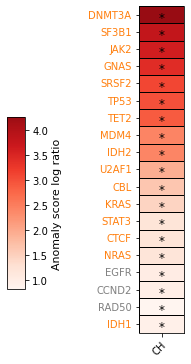

In [193]:
df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(df, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(df, 
                                                                                 cohort_df, 
                                                                                 top_cohorts_n=top_cohorts_n, 
                                                                                 top_genes_n=top_genes_n, 
                                                                                 anomaly_dict=False)

df_binary.columns = [cohort.split("_")[2] for cohort in df_binary.columns]
df_anomaly.columns = [cohort.split("_")[2] for cohort in df_anomaly.columns]
gene_colors, lut = get_gene_annotation(df_binary, df)

plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=df_anomaly,
               figsize=(1,8),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-10.5, 0.95),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.05,
               cbar_loc=[-1.7, 0.2, 0.25, .3],
               filename="landscape_heatmap_ch.png")

# Mouse

In [283]:
genetables_path = "/workspace/projects/clustering_3d/evaluation/tool_output/run_20230608_mouse/Liver_strelka_2017.3d_clustering_genes.csv"
genetables_path

'/workspace/projects/clustering_3d/evaluation/tool_output/run_20230608_mouse/Liver_strelka_2017.3d_clustering_genes.csv'

In [284]:
df = pd.read_csv(genetables_path)
df = df[df["qval"] < 0.01]
df = df[["Gene", "Score_obs_sim_top_vol"]].set_index("Gene")
max_value = df.values[np.isfinite(df.values)].max()
df.replace([np.inf, -np.inf], max_value * 2, inplace=True)
df = np.log(df)
df

,Ratio_obs_sim_top_vol
Gene,
Hras,5.200429
Braf,4.507282
H2-M5,4.181026
Nrcam,4.026246
Ncl,3.545151
Itga9,3.314650
Nkx2-5,3.080942
Olfr1242,2.865297
Egfr,2.791804


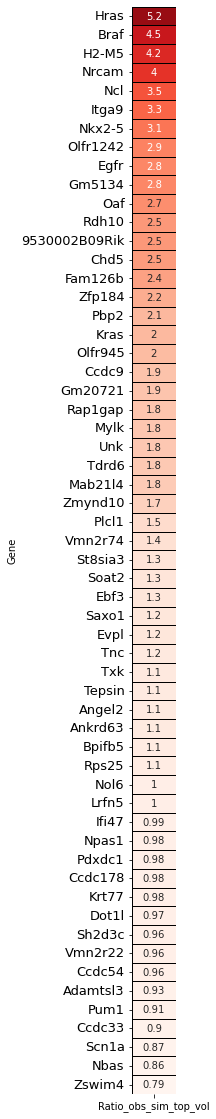

In [313]:
fig = plt.figure(figsize=(0.8,20))
sns.heatmap(df, annot=True, cmap=cmap, cbar=False, lw=1, linecolor="black")
plt.yticks(fontsize=13)

plt.savefig("landscape_mouse.png", dpi=300, bbox_inches='tight')
plt.show()

# Clusters solvent accessibility and more

In [7]:
import os
from tqdm.notebook import tqdm

cohort_df = pd.read_csv(f"{datasets}/cohorts.tsv", sep="\t")
seq_df = pd.read_csv("/workspace/projects/clustering_3d/clustering_3d/datasets/seq_for_mut_prob.csv")
gene_to_uni_id_dict = {gene : uni_id for gene, uni_id in seq_df[["Gene", "Uniprot_ID"]].values}
plddt = pd.read_csv("/workspace/projects/clustering_3d/clustering_3d/datasets/confidence.csv")
plddt = plddt[["Uniprot_ID", "Confidence"]]
pacc = pd.read_csv("/workspace/projects/alphafold_features/feature_extraction/pdb_tool/pdb_tool_result_all_prot.csv")
pacc = pacc[["Gene", "Uniprot_ID", "pACC"]]
intogen_df = pd.read_csv("/workspace/projects/clustering_3d/o3d_analysys/datasets/Intogen_Compendium_Cancer_Genes.tsv", sep="\t")

/tmp/jobs/spellegrini/8977526/ipykernel_42526/3113828103.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  plddt = pd.read_csv("/workspace/projects/clustering_3d/clustering_3d/datasets/confidence.csv")


### Retrieve cluster mean of pACC and other metrics

In [8]:
lst_result = []
for cohort in tqdm(cohort_df.COHORT):
    gene_df_path = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.tsv"
    res_df_path = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
    
    if os.path.isfile(gene_df_path):
        if os.path.isfile(res_df_path):
            gene_df = pd.read_csv(gene_df_path)
            res_df = pd.read_csv(res_df_path)

            hits = gene_df[gene_df["C_gene"] == 1]
            hits = hits["Gene"].values

            for gene in hits:
                print(cohort, gene)
                hits_res = res_df[(res_df["Gene"] == gene) & (res_df["C"] == 1)]
                plddt_gene = plddt[plddt["Uniprot_ID"] == gene_to_uni_id_dict[gene]]
                plddt_gene = plddt_gene.Confidence
                pacc_gene = pacc[pacc["Uniprot_ID"] == gene_to_uni_id_dict[gene]]
                pacc_gene = pacc_gene.pACC
                mean_values = hits_res.groupby("Cluster").apply(lambda x: lst_result.append((cohort, gene,
                                                                                             intogen_df[intogen_df["SYMBOL"] == gene].ROLE.unique()[0] if len(intogen_df[intogen_df["SYMBOL"] == gene].ROLE.unique()) > 0 else "NA",
                                                                                             x.Cluster.unique()[0], x.Pos.values, 
                                                                                             np.mean(plddt_gene.iloc[x.Pos.values - 1]), 
                                                                                             np.mean(pacc_gene.iloc[x.Pos.values - 1]),
                                                                                             np.mean(x.PAE_vol))))

cluster_info = pd.DataFrame(lst_result, columns=["Cohort", "Gene", "Gene_action", "Cluster", "Pos", "pLDDT", "pACC", "PAE"])
cluster_info

  0%|          | 0/266 [00:00<?, ?it/s]

HARTWIG_WGS_BLCA_2020 FGFR3
HARTWIG_WGS_BLCA_2020 PIK3CA
HARTWIG_WGS_BLCA_2020 RXRA
HARTWIG_WGS_BLCA_2020 TP53
HARTWIG_WGS_BLCA_2020 FBXW7
HARTWIG_WGS_BLCA_2020 MUC6
HARTWIG_WGS_BRCA_2020 ESR1
HARTWIG_WGS_BRCA_2020 PIK3CA
HARTWIG_WGS_BRCA_2020 TP53
HARTWIG_WGS_BRCA_2020 MUC6
HARTWIG_WGS_BRCA_2020 AKT1
HARTWIG_WGS_BRCA_2020 TSC2
HARTWIG_WGS_BRCA_2020 ERBB2
HARTWIG_WGS_BRCA_2020 KRAS
HARTWIG_WGS_BRCA_2020 GRIN2A
HARTWIG_WGS_BRCA_2020 FOXA1
HARTWIG_WGS_BRCA_2020 SF3B1
HARTWIG_WGS_BRCA_2020 CTCF
HARTWIG_WGS_CESC_2020 PIK3CA
HARTWIG_WGS_CHOL_2020 KRAS
HARTWIG_WGS_CHOL_2020 IDH1
HARTWIG_WGS_CHOL_2020 TP53
HARTWIG_WGS_SBC_2020 KRAS
HARTWIG_WGS_RCC_2020 MUC6
HARTWIG_WGS_OVT_2020 KRAS
HARTWIG_WGS_OVT_2020 TP53
HARTWIG_WGS_OVT_2020 FOXL2
HARTWIG_WGS_OVT_2020 PIK3CA
HARTWIG_WGS_SCLC_2020 TP53
HARTWIG_WGS_NSCLC_2020 KRAS
HARTWIG_WGS_NSCLC_2020 TP53
HARTWIG_WGS_NSCLC_2020 EGFR
HARTWIG_WGS_NSCLC_2020 BRAF
HARTWIG_WGS_NSCLC_2020 CTNNB1
HARTWIG_WGS_NSCLC_2020 MUC6
HARTWIG_WGS_NSCLC_2020 ALK
HARTWIG_WG

,Cohort,Gene,Gene_action,Cluster,Pos,pLDDT,pACC,PAE
0,HARTWIG_WGS_BLCA_2020,FGFR3,Act,0.0,"[248, 249]",53.510000,30.000000,0.882353
1,HARTWIG_WGS_BLCA_2020,FGFR3,Act,1.0,[375],71.980000,36.000000,0.000000
2,HARTWIG_WGS_BLCA_2020,PIK3CA,Act,0.0,"[542, 545, 539]",93.733333,51.666667,0.841270
3,HARTWIG_WGS_BLCA_2020,RXRA,Act,0.0,"[427, 429]",97.780000,23.000000,0.500000
4,HARTWIG_WGS_BLCA_2020,TP53,LoF,0.0,"[282, 281, 273, 285, 280, 132, 287, 135, 278, ...",97.182667,14.200000,0.920424
...,...,...,...,...,...,...,...,...
1547,TCGA_WXS_LUSC,TP53,LoF,4.0,"[105, 106, 109, 110, 111, 144]",97.325000,30.166667,1.017796
1548,TCGA_WXS_LUSC,PIK3CA,Act,0.0,"[542, 545, 547, 539]",94.407500,41.500000,0.865456
1549,TCGA_WXS_LUSC,PIK3CA,Act,1.0,"[1045, 1047]",85.675000,39.000000,1.071429
1550,TCGA_WXS_LUSC,CDKN2A,Act,0.0,"[83, 114, 84, 85, 118, 81, 50, 108, 53, 20, 48]",80.456364,6.818182,2.335793


In [739]:
cluster_info = cluster_info[cluster_info["Gene_action"] != "ambiguous"]

### Plot distributions

In [735]:
df_info_na = cluster_info[cluster_info["Gene_action"] == "NA"].groupby("Gene").apply(lambda x: (len(x.Cohort.unique()), len(x)))
pd.DataFrame(df_info_na.tolist(), index=df_info_na.index, columns=["# cohorts", "# clusters"]).sort_values("# clusters", ascending=False)[:30]

,# cohorts,# clusters
Gene,,
MUC3A,3,25
MUC12,2,22
IGLL5,3,21
MUC17,5,18
HRNR,1,16
MAGEC1,2,15
MUC5AC,4,14
ZAN,2,10
ZNF717,2,9


In [736]:
df_info_amb = cluster_info[cluster_info["Gene_action"] == "ambiguous"].groupby("Gene").apply(lambda x: (len(x.Cohort.unique()), len(x)))
pd.DataFrame(df_info_amb.tolist(), index=df_info_amb.index, columns=["# cohorts", "# clusters"]).sort_values("# clusters", ascending=False)[:30]

,# cohorts,# clusters
Gene,,
GRIN2A,1,1
SDHA,1,1


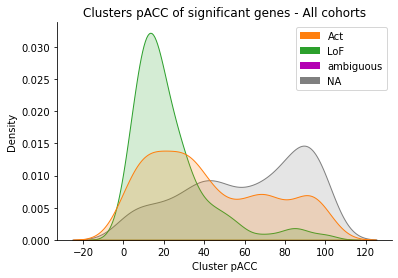

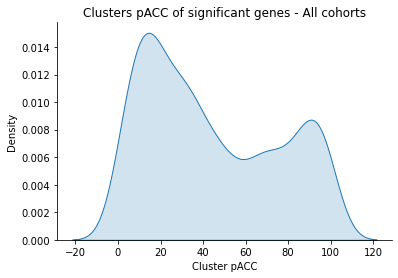

In [740]:
lut = {"Act": '#ff7f0e', 
       "LoF": '#2ca02c',
       "ambiguous" : "#b300b2",
       "NA": '#7f7f7f'}

## Plot 
plt.figure(figsize=(6, 4))
palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': '#7f7f7f'}
sns.kdeplot(data=cluster_info, x='pACC', hue='Gene_action', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Cluster pACC')
plt.ylabel('Density')
plt.title("Clusters pACC of significant genes - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["Act"], label="Act"),
           mpatches.Patch(facecolor=lut["LoF"], label="LoF"),
           mpatches.Patch(facecolor=lut["ambiguous"], label="ambiguous"),
           mpatches.Patch(facecolor=lut["NA"], label="NA")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("pacc_cluster_distribution_by_action.png", dpi=300, bbox_inches='tight')
plt.show()

## Plot 
plt.figure(figsize=(6, 4))
palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': '#7f7f7f'}
sns.kdeplot(data=cluster_info, x='pACC', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Cluster pACC')
plt.ylabel('Density')
plt.title("Clusters pACC of significant genes - All cohorts", fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("pacc_cluster_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

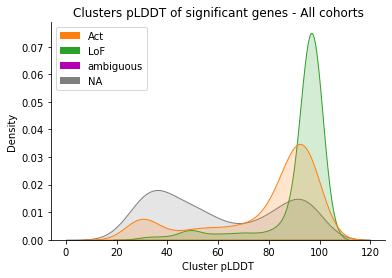

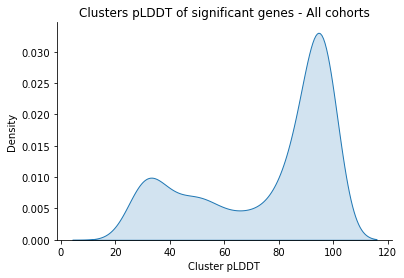

In [741]:
lut = {"Act": '#ff7f0e', 
       "LoF": '#2ca02c',
       "ambiguous" : "#b300b2",
       "NA": '#7f7f7f'}

## Plot 
plt.figure(figsize=(6, 4))
palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': '#7f7f7f'}
sns.kdeplot(data=cluster_info, x='pLDDT', hue='Gene_action', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Cluster pLDDT')
plt.ylabel('Density')
plt.title("Clusters pLDDT of significant genes - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["Act"], label="Act"),
           mpatches.Patch(facecolor=lut["LoF"], label="LoF"),
           mpatches.Patch(facecolor=lut["ambiguous"], label="ambiguous"),
           mpatches.Patch(facecolor=lut["NA"], label="NA")]
plt.legend(handles=handles, loc="upper left")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("plddt_cluster_distribution_by_action.png", dpi=300, bbox_inches='tight')
plt.show()

## Plot 
plt.figure(figsize=(6, 4))
palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': '#7f7f7f'}
sns.kdeplot(data=cluster_info, x='pLDDT', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Cluster pLDDT')
plt.ylabel('Density')
plt.title("Clusters pLDDT of significant genes - All cohorts", fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("plddt_cluster_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

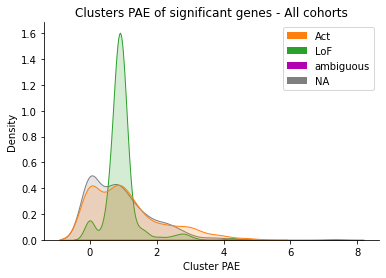

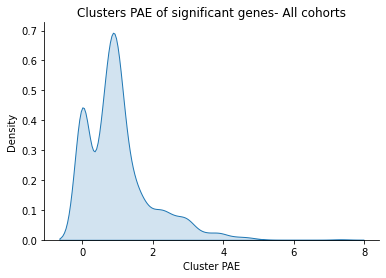

In [742]:
lut = {"Act": '#ff7f0e', 
       "LoF": '#2ca02c',
       "ambiguous" : "#b300b2",
       "NA": '#7f7f7f'}

## Plot 
plt.figure(figsize=(6, 4))
palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': '#7f7f7f'}
sns.kdeplot(data=cluster_info, x='PAE', hue='Gene_action', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Cluster PAE')
plt.ylabel('Density')
plt.title("Clusters PAE of significant genes - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["Act"], label="Act"),
           mpatches.Patch(facecolor=lut["LoF"], label="LoF"),
           mpatches.Patch(facecolor=lut["ambiguous"], label="ambiguous"),
           mpatches.Patch(facecolor=lut["NA"], label="NA")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("pae_cluster_distribution_by_action.png", dpi=300, bbox_inches='tight')
plt.show()

## Plot 
plt.figure(figsize=(6, 4))
palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': '#7f7f7f'}
sns.kdeplot(data=cluster_info, x='PAE', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Cluster PAE')
plt.ylabel('Density')
plt.title("Clusters PAE of significant genes- All cohorts", fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("pae_cluster_distribution.png", dpi=300, bbox_inches='tight')
plt.show()